In [ ]:
ريهام محمد عبدالفتاح احمد#
import tensorflow as tf
!pip install d2l
from d2l import tensorflow as d2l

In [2]:
# download data 
d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip',
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')

data_dir = d2l.download_extract('pokemon')
batch_size = 256
pokemon = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, batch_size=batch_size, image_size=(64, 64))

Found 40597 files belonging to 721 classes.


In [3]:
#normalize data 
def transform_func(X):
    X = X / 255.
    X = (X - 0.5) / (0.5)
    return X

# For TF>=2.4 use `num_parallel_calls = tf.data.AUTOTUNE`
data_iter = pokemon.map(lambda x, y: (transform_func(x), y),
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
data_iter = data_iter.cache().shuffle(buffer_size=1000).prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)

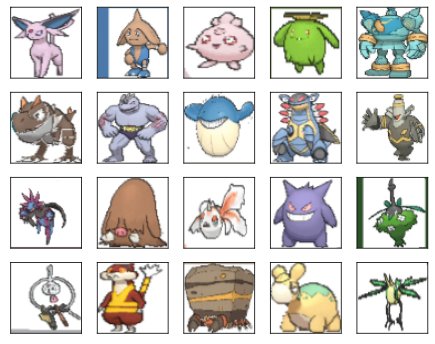

In [4]:
#show the first 20 images
d2l.set_figsize(figsize=(4, 4))
for X, y in data_iter.take(1):
    imgs = X[:20, :, :, :] / 2 + 0.5
    d2l.show_images(imgs, num_rows=4, num_cols=5)

In [6]:
class G_block(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size=4, strides=2, padding="same",
                 **kwargs):
        super().__init__(**kwargs)
        self.conv2d_trans = tf.keras.layers.Conv2DTranspose(
            out_channels, kernel_size, strides, padding, use_bias=False)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.ReLU()

    def call(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

In [7]:
x = tf.zeros((2, 16, 16, 3))  # Channel last convention
g_blk = G_block(20)
g_blk(x).shape

TensorShape([2, 32, 32, 20])

In [8]:
x = tf.zeros((2, 1, 1, 3))
# `padding="valid"` corresponds to no padding
g_blk = G_block(20, strides=1, padding="valid")
g_blk(x).shape

TensorShape([2, 4, 4, 20])

In [10]:
n_G = 64
net_G = tf.keras.Sequential([
    # Output: (4, 4, 64 * 8)
    G_block(out_channels=n_G * 8, strides=1, padding="valid"),
    G_block(out_channels=n_G * 4),  # Output: (8, 8, 64 * 4)
    G_block(out_channels=n_G * 2),  # Output: (16, 16, 64 * 2)
    G_block(out_channels=n_G),  # Output: (32, 32, 64)
    # Output: (64, 64, 3)
    tf.keras.layers.Conv2DTranspose(3, kernel_size=4, strides=2,
                                    padding="same", use_bias=False,
                                    activation="tanh")])

In [11]:
x = tf.zeros((1, 1, 1, 100))
net_G(x).shape

TensorShape([1, 64, 64, 3])

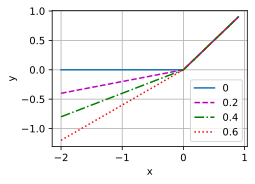

In [12]:
alphas = [0, .2, .4, .6, .8, 1]
x = tf.range(-2, 1, 0.1)
Y = [tf.keras.layers.LeakyReLU(alpha)(x).numpy() for alpha in alphas]
d2l.plot(x.numpy(), Y, 'x', 'y', alphas)

In [14]:
class D_block(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size=4, strides=2, padding="same",
                 alpha=0.2, **kwargs):
        super().__init__(**kwargs)
        self.conv2d = tf.keras.layers.Conv2D(out_channels, kernel_size,
                                             strides, padding, use_bias=False)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.LeakyReLU(alpha)

    def call(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

In [15]:
x = tf.zeros((2, 16, 16, 3))
d_blk = D_block(20)
d_blk(x).shape

TensorShape([2, 8, 8, 20])

In [16]:
n_D = 64
net_D = tf.keras.Sequential([
    D_block(n_D),  # Output: (32, 32, 64)
    D_block(out_channels=n_D * 2),  # Output: (16, 16, 64 * 2)
    D_block(out_channels=n_D * 4),  # Output: (8, 8, 64 * 4)
    D_block(out_channels=n_D * 8),  # Outupt: (4, 4, 64 * 64)
    # Output: (1, 1, 1)
    tf.keras.layers.Conv2D(1, kernel_size=4, use_bias=False)])

In [17]:
x = tf.zeros((1, 64, 64, 3))
net_D(x).shape

TensorShape([1, 1, 1, 1])

In [18]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          device=d2l.try_gpu()):
    loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.SUM)

    for w in net_D.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))
    for w in net_G.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))

    optimizer_hp = {"lr": lr, "beta_1": 0.5, "beta_2": 0.999}
    optimizer_D = tf.keras.optimizers.Adam(**optimizer_hp)
    optimizer_G = tf.keras.optimizers.Adam(**optimizer_hp)

    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)

    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = tf.random.normal(mean=0, stddev=1,
                                 shape=(batch_size, 1, 1, latent_dim))
            metric.add(d2l.update_D(X, Z, net_D, net_G, loss, optimizer_D),
                       d2l.update_G(Z, net_D, net_G, loss, optimizer_G),
                       batch_size)

        # Show generated examples
        Z = tf.random.normal(mean=0, stddev=1, shape=(21, 1, 1, latent_dim))
        # Normalize the synthetic data to N(0, 1)
        fake_x = net_G(Z) / 2 + 0.5
        imgs = tf.concat([
            tf.concat([fake_x[i * 7 + j] for j in range(7)], axis=1)
            for i in range(len(fake_x) // 7)], axis=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device)}')

loss_D 0.292, loss_G 2.748, 319.5 examples/sec on <tensorflow.python.eager.context._EagerDeviceContext object at 0x7f8f60292190>


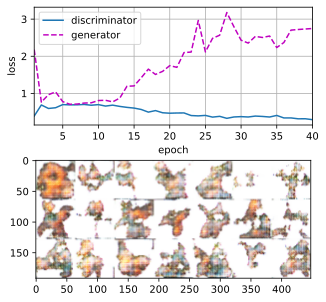

In [19]:
latent_dim, lr, num_epochs = 100, 0.0005, 40
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)